# 0. Data Loading and Libraries

In [27]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [28]:
# Loading data
df_train = pd.read_csv("../../data/train_data.csv")
df_test = pd.read_csv("../../data/test_data.csv")

C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\3698058545.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../../data/train_data.csv")


# 1. Exploratory Analysis

## Helper functions

In [29]:
def convert_dates(df, date_columns):
    """Convert specified columns to datetime."""
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [30]:
def basic_descriptive_stats(df):
    """Display basic descriptive statistics for a DataFrame."""
    print("First 5 rows:")
    display(df.head())
    print("\nData Info:")
    display(df.info())
    print("\nNumerical Features Description:")
    display(df.describe())
    print("\nCategorical Features Description:")
    display(df.describe(include=['object', 'category']))
    print("\nMissing Values Summary:")
    print(df.isna().sum())
    print("\nDuplicate Check:")
    print(f"Number of duplicates: {df.duplicated().sum()}")


In [31]:
def feature_splitting(df, threshold=25):
    """Splits the DataFrame columns into date, categorical, high cardinality categorical, and numerical features."""
    date_features = [col for col in df.columns if 'Date' in col]
    non_metric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    non_metric_high_cardinality = [col for col in non_metric_features if df[col].nunique() > threshold]
    metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("Non-metric (Categorical) features:", non_metric_features)
    print("Non-metric (High Cardinality) features:", non_metric_high_cardinality)
    print("Metric (Numerical) features:", metric_features)
    
    return date_features, non_metric_features, non_metric_high_cardinality, metric_features

# Use for both train and test sets
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)


Non-metric (Categorical) features: ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']
Non-metric (High Cardinality) features: ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Pa

In [32]:
def check_missing_patterns(df, columns_to_check):
    """Checks if certain variables have all their missing values in the same rows."""
    for col in columns_to_check:
        missing_rows = df[df[col].isna()][columns_to_check]
        display(missing_rows.info())


In [33]:
def num_dist(df, metric_features, bins=30):
    """Display histograms of numerical features."""
    df[metric_features].hist(bins=bins, figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Variables")
    plt.show()


In [34]:
def cat_counts_and_plots(df, excl_feat=[]):
    """Display value counts and plots for categorical features, excluding high cardinality features if needed."""
    for column in df.select_dtypes(include='object').columns:
        if column not in excl_feat:
            print(f"Value counts for {column}:")
            print(df[column].value_counts())
            print("\n")
            
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
            plt.xticks(rotation=90)
            plt.show()


In [35]:
def plot_bar(df, col, degrees=0):
    """Plot a bar chart for a specified column."""
    column = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column.index.astype(str), y=column.values)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=degrees)
    plt.show()

def plot_hist(df, col, rotate=False):
    """Plot a histogram for a specified column with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

def plot_box(df, col):
    """Plot a boxplot for a specified column."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.xlabel(col)
    plt.show()

def plot_pie(df, col):
    """Plot a pie chart for a specified column with percentage thresholds."""
    value_counts = df[col].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total) * 100

    above_threshold = percentages[percentages >= 2]
    below_threshold = percentages[percentages < 2]

    if len(below_threshold) > 0:
        other_percentage = below_threshold.sum()
        above_threshold['Others'] = other_percentage

    plt.figure(figsize=(8, 8))
    above_threshold.plot.pie(autopct='%1.1f%%', startangle=90, labels=above_threshold.index)
    plt.ylabel("")
    plt.xlabel(col)
    plt.legend(title="Legend", loc='upper left')
    plt.show()

def plot_heatmap(df, numerical_features):
    """Display heatmap of correlation among numerical features."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.1f')
    plt.show()


In [36]:
# NEW
def cast_code_columns(df, code_identifiers=['Code']):
    """
    Cast columns with names containing keywords (e.g., 'Code') to categorical data type, ignoring case.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        code_identifiers (list): List of keywords to identify code columns. Default is ['Code'].
    
    Returns:
        pd.DataFrame: The modified DataFrame with code columns cast to categorical.
    """
    # Convert code_identifiers to lowercase for case-insensitive matching
    code_identifiers = [keyword.lower() for keyword in code_identifiers]

    # Loop through columns to find those that match code identifiers, case-insensitively
    for col in df.columns:
        if any(keyword in col.lower() for keyword in code_identifiers):
            # Check if the column is currently numeric, then cast to category
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].astype('category')
                print(f"Column '{col}' cast to 'category' data type.")
            else:
                print(f"Column '{col}' already non-numeric, no casting applied.")
    
    return df


In [37]:
# Cast code columns to categorical in both train and test datasets
df_train = cast_code_columns(df_train)
df_test = cast_code_columns(df_test)

Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.
Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.


In [38]:
# Define date columns
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
convert_dates(df_train, date_columns)
convert_dates(df_test, date_columns)

## Step 1: General descr. stats

In [39]:
basic_descriptive_stats(df_train)

First 5 rows:


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 

None


Numerical Features Description:


,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,OIICS Nature of Injury Description,Agreement Reached,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,0.0,574026.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,NaN,0.046665,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,NaN,0.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,NaN,0.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,NaN,0.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,NaN,0.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,NaN,1.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,NaN,0.210921,2.000801



Categorical Features Description:


,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,574026,574026,574026,574026,574026,564068.0,564068,574026,558386.0,558386,558369.0,558369,556944.0,556944,545389,574026
unique,3,2,2046,8,8,63,2,8,4,24.0,20,5,77.0,74,56.0,56,57.0,54,10060,1
top,N,N,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,M,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,IV,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11236,Not Work Related
freq,571412,392291,111144,285368,291078,60430,546505,270779,335218,114339.0,114339,265981,46610.0,46610,153373.0,153373,51862.0,51862,3302,574026



Missing Values Summary:
Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region            

## Step 2: Single Feature analysis

In [40]:
# For each column
    # Descriptive stats
    # Visualization (Bar, hist, boxplot, .., whatever makes sense)
        # Use above helper function
    # Problems (missing values, invalid values etc.)
        # show examples etc.
    # how to deal with the problems
        # remove rows? replace with null? what happens to null values (replace with median, knN, mode etc)?
        # analyse and find solution with train -> apply solution to train and test

In [41]:
# Empty columns: WCB Decision (in test), OIICS Nature of Injury Description, Agreement Reached
    # Ignore those

In [42]:
# Daniel: 
"""
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64    
 3   Assembly Date                       593471 non-null  datetime64[ns]
 6   Birth Year                          544948 non-null  float64    
 7   C-2 Date                            559466 non-null  datetime64[ns] 
 8   C-3 Date                            187245 non-null  datetime64[ns]
 16  First Hearing Date                  150798 non-null  datetime64[ns]
 2   Alternative Dispute Resolution      574026 non-null  object    
 4   Attorney/Representative             574026 non-null  object       
 10  Carrier Type                        574026 non-null  object        
 13  County of Injury                    574026 non-null  object         
 """

'\n 0   Accident Date                       570337 non-null  datetime64[ns]\n 1   Age at Injury                       574026 non-null  float64    \n 3   Assembly Date                       593471 non-null  datetime64[ns]\n 6   Birth Year                          544948 non-null  float64    \n 7   C-2 Date                            559466 non-null  datetime64[ns] \n 8   C-3 Date                            187245 non-null  datetime64[ns]\n 16  First Hearing Date                  150798 non-null  datetime64[ns]\n 2   Alternative Dispute Resolution      574026 non-null  object    \n 4   Attorney/Representative             574026 non-null  object       \n 10  Carrier Type                        574026 non-null  object        \n 13  County of Injury                    574026 non-null  object         \n '

In [43]:
# Louis: 
"""
 19  Industry Code                       564068 non-null  float64       
 20  Industry Code Description           564068 non-null  object        
 21  Medical Fee Region                  574026 non-null  object     
 23  WCIO Cause of Injury Code           558386 non-null  float64       
 24  WCIO Cause of Injury Description    558386 non-null  object        
 25  WCIO Nature of Injury Code          558369 non-null  float64       
 26  WCIO Nature of Injury Description   558369 non-null  object        
 27  WCIO Part Of Body Code              556944 non-null  float64       
 28  WCIO Part Of Body Description       556944 non-null  object        
 29  Zip Code                            545389 non-null  object 
 12  Claim Injury Type                   574026 non-null  object
 17  Gender                              574026 non-null  object        
"""

'\n 19  Industry Code                       564068 non-null  float64       \n 20  Industry Code Description           564068 non-null  object        \n 21  Medical Fee Region                  574026 non-null  object     \n 23  WCIO Cause of Injury Code           558386 non-null  float64       \n 24  WCIO Cause of Injury Description    558386 non-null  object        \n 25  WCIO Nature of Injury Code          558369 non-null  float64       \n 26  WCIO Nature of Injury Description   558369 non-null  object        \n 27  WCIO Part Of Body Code              556944 non-null  float64       \n 28  WCIO Part Of Body Description       556944 non-null  object        \n 29  Zip Code                            545389 non-null  object \n 12  Claim Injury Type                   574026 non-null  object\n 17  Gender                              574026 non-null  object        \n'

In [44]:
def initial_analysis(df, column_name):
    """
    Perform initial descriptive statistics and visualization for a single column,
    handling categorical (object and category) and numerical columns appropriately.
    """
    print(f"\n\n### Initial Analysis for Column: {column_name} ###\n")
    
    # Descriptive Statistics
    print("Descriptive Statistics:")
    print(df[column_name].describe())
    print("\nValue Counts:")
    print(df[column_name].value_counts(dropna=False))

    # Missing values
    missing_values = df[column_name].isna().sum()
    print(f"\nMissing Values: {missing_values}")

    # Visualization
    print("\nVisualization:")
    if pd.api.types.is_numeric_dtype(df[column_name]):
        # For numerical columns
        plot_hist(df, column_name)    # Histogram for numerical data
        plot_box(df, column_name)     # Boxplot for outlier detection
    elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):
        # For categorical columns (object or category)
        if df[column_name].nunique() < 25:  # Use bar plot for low cardinality
            plot_bar(df, column_name, degrees=45)
        else:  # Use pie chart for high cardinality
            plot_pie(df, column_name)


### Industry Code & Industry Code Description



### Initial Analysis for Column: Industry Code ###

Descriptive Statistics:
count     564068.0
unique        24.0
top           62.0
freq      114339.0
Name: Industry Code, dtype: float64

Value Counts:
Industry Code
 62.0    114339
 92.0     92240
 61.0     44393
 44.0     43685
 48.0     37319
 23.0     30903
NaN       29403
 72.0     26456
 56.0     21027
 45.0     17953
 33.0     17232
 49.0     16704
 42.0     15236
 81.0     13149
 32.0     10804
 31.0     10114
 71.0      9967
 54.0      9770
 51.0      9166
 53.0      8948
 52.0      8214
 22.0      2980
 11.0      2404
 21.0       695
 55.0       370
Name: count, dtype: int64

Missing Values: 29403

Visualization:


C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


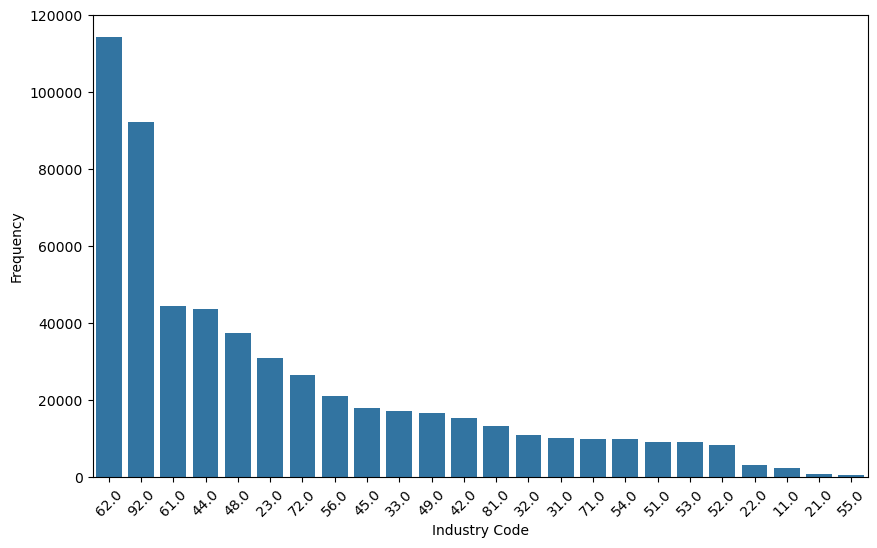

In [45]:
# Initial Analysis for Industry Code
initial_analysis(df_train, "Industry Code")

Replacing with a 0 Code, unknown industry code.

### Medical fee region



### Initial Analysis for Column: Medical Fee Region ###

Descriptive Statistics:
count     574026
unique         5
top           IV
freq      265981
Name: Medical Fee Region, dtype: object

Value Counts:
Medical Fee Region
IV     265981
I      135885
II      85033
III     53654
UK      33473
NaN     19445
Name: count, dtype: int64

Missing Values: 19445

Visualization:


C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


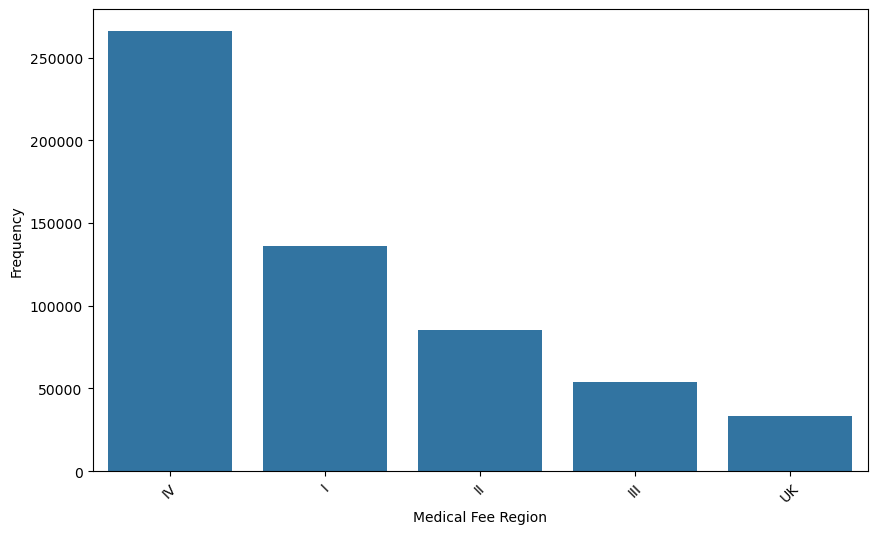

In [47]:
# Initial Analysis for Medical Fee Region
initial_analysis(df_train, "Medical Fee Region")

### WCIO Cause of Injury Code and WCIO Cause of Injury Description



### Initial Analysis for Column: WCIO Cause of Injury Code ###

Descriptive Statistics:
count     558386.0
unique        77.0
top           56.0
freq       46610.0
Name: WCIO Cause of Injury Code, dtype: float64

Value Counts:
WCIO Cause of Injury Code
 56.0    46610
 74.0    37153
NaN      35085
 60.0    33192
 31.0    31733
         ...  
 91.0       55
 14.0       51
 40.0       45
 8.0        34
 47.0       12
Name: count, Length: 78, dtype: int64

Missing Values: 35085

Visualization:


C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


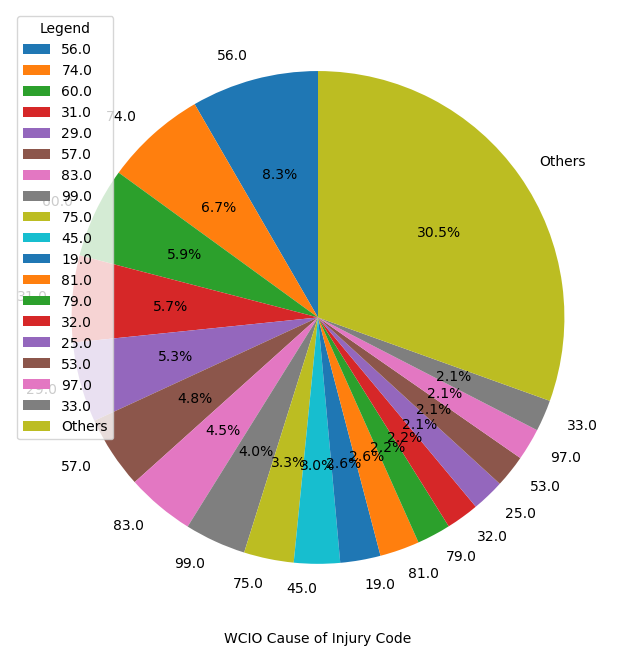

In [24]:
# Initial Analysis for WCIO Cause of Injury Code
initial_analysis(df_train, "WCIO Cause of Injury Code")

### WCIO Nature of Injury Code and WCIO Nature of Injury Description



### Initial Analysis for Column: WCIO Nature of Injury Code ###

Descriptive Statistics:
count     558369.0
unique        56.0
top           52.0
freq      153373.0
Name: WCIO Nature of Injury Code, dtype: float64

Value Counts:
WCIO Nature of Injury Code
 52.0    153373
 10.0    110717
 49.0     55789
 40.0     47157
 59.0     36101
NaN       35102
 83.0     25724
 28.0     22673
 43.0     17350
 90.0     12734
 37.0     12491
 4.0       7525
 25.0      7386
 1.0       5961
 16.0      5867
 7.0       5484
 13.0      5218
 78.0      2806
 80.0      2798
 34.0      2705
 31.0      1946
 71.0      1917
 77.0      1569
 53.0      1426
 65.0      1306
 46.0      1246
 68.0      1035
 36.0       941
 72.0       862
 2.0        736
 73.0       722
 19.0       619
 41.0       462
 69.0       452
 32.0       425
 42.0       396
 91.0       375
 47.0       340
 66.0       290
 58.0       269
 74.0       189
 38.0       185
 3.0        181
 55.0       157
 61.0       112
 54.0        94
 60.0 

C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


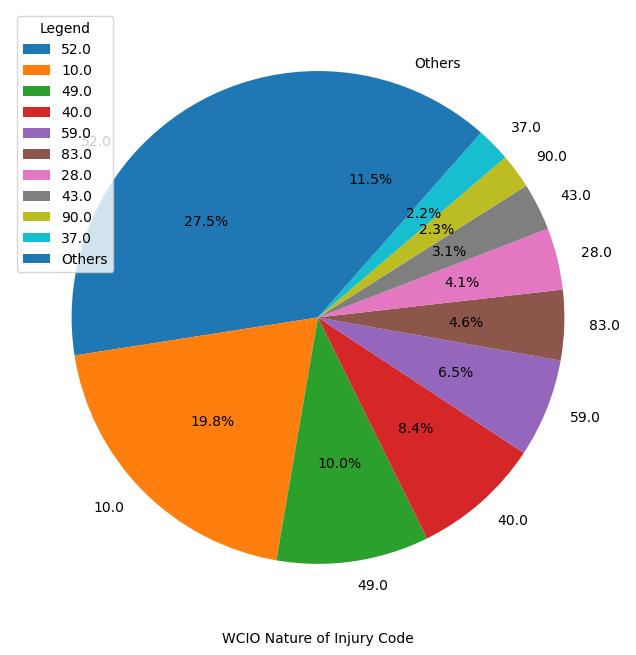

In [49]:
# Initial Analysis for WCIO Nature of Injury Code
initial_analysis(df_train, "WCIO Nature of Injury Code")

### WCIO Part of Body Code and WCIO Part of Body Description



### Initial Analysis for Column: WCIO Part Of Body Code ###

Descriptive Statistics:
count     556944.0
unique        57.0
top           42.0
freq       51862.0
Name: WCIO Part Of Body Code, dtype: float64

Value Counts:
WCIO Part Of Body Code
 42.0    51862
 53.0    47903
-9.0     42011
 38.0    37811
NaN      36527
 36.0    36093
 35.0    31388
 55.0    24928
 90.0    22608
 56.0    18765
 34.0    18750
 33.0    15372
 60.0    14000
 18.0    13765
 14.0    12975
 37.0    12525
 54.0    11622
 31.0    11236
 91.0    10950
 32.0     9949
 41.0     8240
 10.0     7939
 11.0     7904
 44.0     7644
 61.0     6770
 51.0     6430
 66.0     6103
 25.0     5938
 65.0     5311
 52.0     4296
 13.0     3912
 19.0     3905
 48.0     3759
 20.0     2848
 30.0     2633
 39.0     2623
 57.0     2535
 15.0     2091
 63.0     1998
 12.0     1989
 50.0     1927
 43.0     1893
 58.0     1806
 40.0     1752
 17.0     1602
 21.0     1332
 99.0     1249
 62.0     1161
 22.0     1103
 16.0      803
 46.

C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


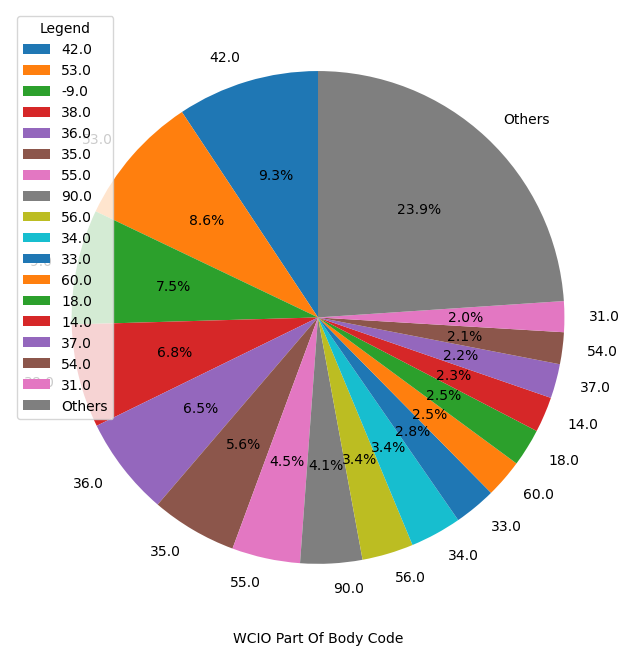

In [50]:
# Initial Analysis for WCIO Part of Body Code
initial_analysis(df_train, "WCIO Part Of Body Code")

### Zip Code



### Initial Analysis for Column: Zip Code ###

Descriptive Statistics:
count     545389
unique     10060
top        11236
freq        3302
Name: Zip Code, dtype: object

Value Counts:
Zip Code
NaN      48082
11236     3302
10940     2971
11717     2807
11434     2759
         ...  
28092        1
80033        1
52163        1
17813        1
07122        1
Name: count, Length: 10061, dtype: int64

Missing Values: 48082

Visualization:


C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


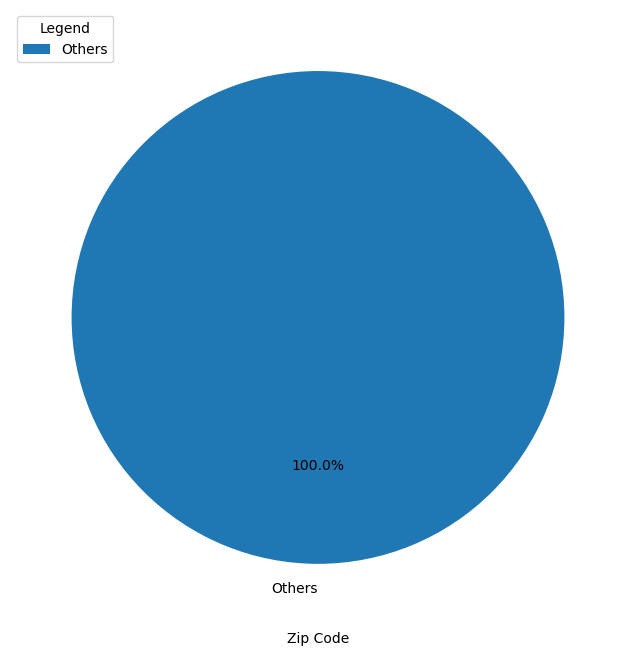

In [51]:
# Initial Analysis for Zip Code
initial_analysis(df_train, "Zip Code")

### Claim Injury Type



### Initial Analysis for Column: Claim Injury Type ###

Descriptive Statistics:
count          574026
unique              8
top       2. NON-COMP
freq           291078
Name: Claim Injury Type, dtype: object

Value Counts:
Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
NaN                 19445
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

Missing Values: 19445

Visualization:


C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


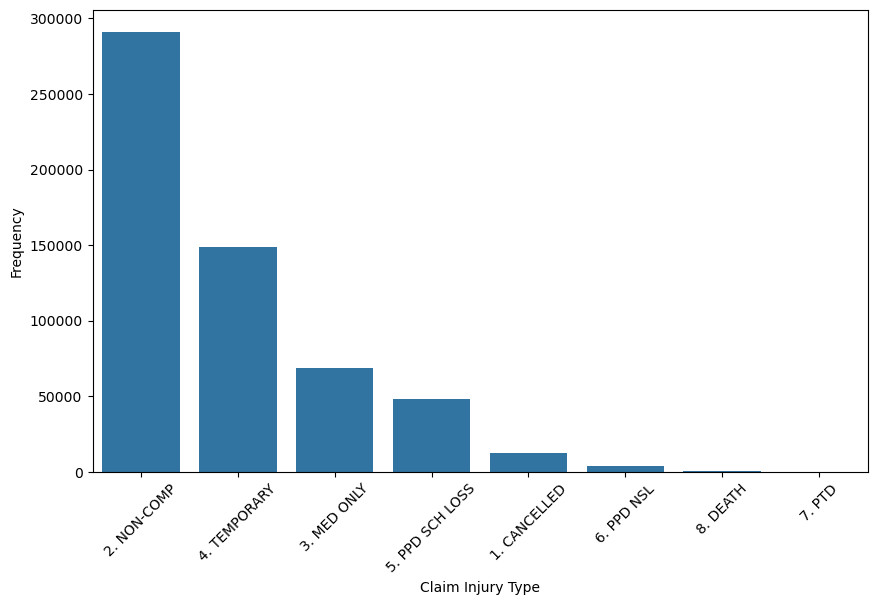

In [52]:
# Initial Analysis for Claim Injury Type
initial_analysis(df_train, "Claim Injury Type")

### Gender



### Initial Analysis for Column: Gender ###

Descriptive Statistics:
count     574026
unique         4
top            M
freq      335218
Name: Gender, dtype: object

Value Counts:
Gender
M      335218
F      234051
NaN     19445
U        4711
X          46
Name: count, dtype: int64

Missing Values: 19445

Visualization:


C:\Users\Louis\AppData\Local\Temp\ipykernel_31748\4198402081.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column_name]) or pd.api.types.is_object_dtype(df[column_name]):


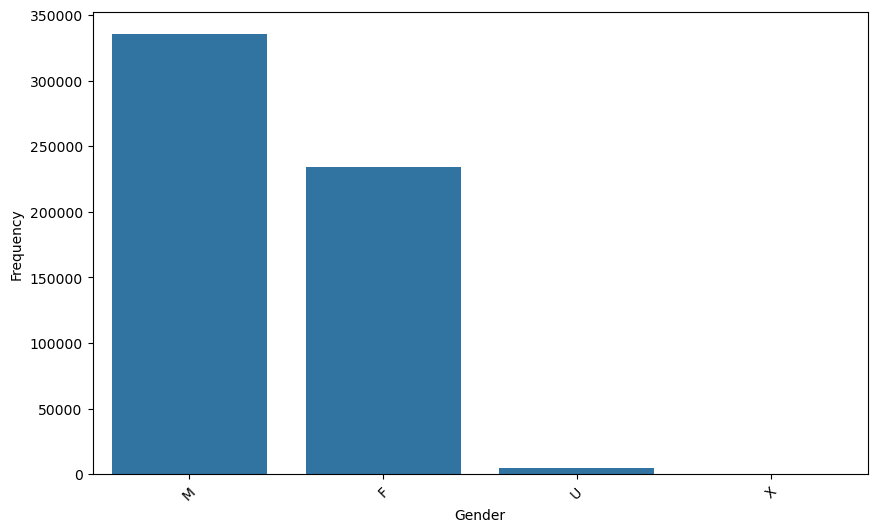

In [53]:
# Initial Analysis for Gender
initial_analysis(df_train, "Gender")

In [29]:
# Rita: 
"""
 5   Average Weekly Wage                 545375 non-null  float64       
 9   Carrier Name                        574026 non-null  object        
 11  Claim Identifier                    593471 non-null  int64         
 14  COVID-19 Indicator                  574026 non-null  object        
 15  District Name                       574026 non-null  object        
 18  IME-4 Count                         132803 non-null  float64       
 22  Number of Dependents                574026 non-null  float64       
"""

'\n 5   Average Weekly Wage                 545375 non-null  float64       \n 9   Carrier Name                        574026 non-null  object        \n 11  Claim Identifier                    593471 non-null  int64         \n 14  COVID-19 Indicator                  574026 non-null  object        \n 15  District Name                       574026 non-null  object        \n 18  IME-4 Count                         132803 non-null  float64       \n 22  Number of Dependents                574026 non-null  float64       \n'

## Step 3: Cross-Feature analysis

In [21]:
# cross-feature inconsistencies
    # all dates have to be after incident date
    # if covid code -> covid has to be true
    # code vs description (just check, we will ignore the descriptions later)
    # How to deal with inconsistencies
# cross-feature visualisations
    # Write down Visualisation insights

# Re-Run of Exploratory Analysis